# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mnOPSuite.PRISM.python import scandelay_FTIR as sd
from importlib import reload

from scipy.optimize import leastsq,minimize
from scipy.stats import binned_statistic
from scipy.interpolate import interp1d
from common import numerical_recipes as numrec
from common.baseclasses import AWA
from common import numerics as num
import time
import warnings
warnings.filterwarnings('ignore')

dX=None
flattening_order=10
Nx=20
interp_kwargs=dict(bounds_error=False,
                   fill_value=0,
                   kind='cubic')
delay_calibration_factor=-2.5

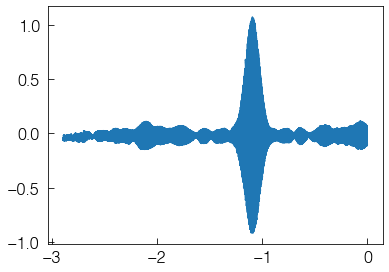

In [58]:
intfgs_arr=np.loadtxt('interferograms.txt')
plt.figure()
i=0
plt.plot(intfgs_arr[2*i+1],intfgs_arr[2*i])

# Rolling alignment

In [65]:
intfgs=[]
xs=[]

Ncycles = len(intfgs_arr) // 2
Nintfgms = Ncycles*2
Nx=100

all_xs = []
all_intfgs = []
for i in range(Ncycles):
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    N = len(xs)

    #fwd:
    x = xs[:int(N // 2)]
    y = ys[:int(N // 2)]
    
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
        
    all_xs.append(x); all_intfgs.append(y)
    #bwd
    #x = xs[int(N // 2):]
    #y = ys[int(N // 2):]
    #all_xs.append(x); all_intfgs.append(y)
    
all_xs=np.array(all_xs)
all_xs *= delay_calibration_factor
x0 *= delay_calibration_factor
    

def roll_intfgs(rs):
    
    intfgs_rolled=[]
    for r,intfg in zip(rs,all_intfgs):
        intfg_rolled=np.roll(intfg,int(r))
        intfgs_rolled.append(intfg_rolled)
        
    return np.array(intfgs_rolled)

def roll_xs(rs):
    
    xs_rolled=[]
    for r,x in zip(rs,all_xs):
        x_rolled=np.roll(x,int(r))
        xs_rolled.append(x_rolled)
        
    return np.array(xs_rolled)

def to_minimize(rs):
    
    intfgs_rolled=roll_intfgs(rs)
    
    return -np.sum(intfgs_rolled**2)

   
rs=minimize(to_minimize,[0]*Nintfgms).x
intfg_new = np.mean(roll_intfgs(rs),axis=0)
xnew = np.mean(roll_xs(rs),axis=0)
intfg_interp = interp1d(x=xnew,y=intfg_new,**interp_kwargs)

x1=np.min(all_xs)
if dX is None:
    dX=np.max(all_xs)-x1
    
xnew1 = np.linspace(x1,x1+dX,len(xnew))
intfg_new1=intfg_interp(xnew1)
    


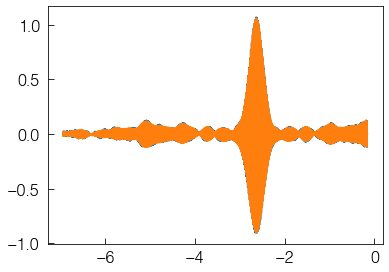

In [60]:
#plt.plot(x)
plt.figure()
plt.plot(x0,intfg0)#,x,intfg1)
plt.plot(xnew1,intfg_new1)#,x,intfg1)
#plt.xlim(-1.15,-1.05)
#plt.ylim(-2.7,-2)

<common.numerics.Spectrum.__new__>:
	Interpolating to evenly-spaced samples along *axis*.


(1500.0, 1800.0)

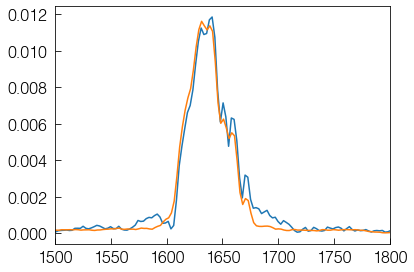

In [61]:
result0=sd.fourier_xform([intfg0,x0],tsubtract=0,envelope=True)
result1=sd.fourier_xform([intfg_new1,xnew1],tsubtract=0,envelope=True)
plt.figure()
plt.plot(result0[0],result0[1])
plt.plot(result1[0],result1[1])

plt.xlim(1500,1800)

# Shifting alignment

In [71]:
intfgs_arr=np.loadtxt('interferograms.txt')

Ncycles = len(intfgs_arr) // 2
Ncycles = np.min((20,Ncycles))
Nintfgms = Ncycles*2

all_xs = []
all_intfg_interps = []
for i in range(Ncycles):
    #i=i+10
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    N = len(xs)

    #fwd:
    x = xs[:int(N // 2)]*delay_calibration_factor
    y = ys[:int(N // 2)]
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
    all_xs.append(x)
    all_intfg_interps.append( interp1d(x=x,y=y,**interp_kwargs) )
    #bwd
    #x = xs[int(N // 2):]
    #y = ys[int(N // 2):]
    #all_xs.append(x); all_intfgs.append(y)
    
all_xs=np.array(all_xs)
    
x1=np.min(all_xs)
x2=np.max(all_xs)
if dX is None: dX = x2-x1

def get_dx(x):
    
    wl = 2*dX
    return np.sin(2*np.pi*(x-x1)/wl)
    
def get_intfg_shifted(rs):
    
    intfgs_shifted=[]
    for r,x,intfg_interp in zip(rs,all_xs,all_intfg_interps):
        dx=get_dx(x)
        intfg_rolled=intfg_interp(x+r*dx)
        intfgs_shifted.append(intfg_rolled)
        
    return np.mean(intfgs_shifted,axis=0)

def get_x_shifted(rs):
    
    xs_shifted=[]
    for r,x in zip(rs,all_xs):
        dx=get_dx(x)
        xs_shifted.append(x+r*dx)
        
    return np.mean(xs_shifted,axis=0)

def to_minimize(rs):
    
    intfg_shifted=get_intfg_shifted(rs)
    
    return -np.sum(intfg_shifted**2)
   
t=time.time()
rs=minimize(to_minimize,[0]*Nintfgms,
           bounds=[(-.01,.01)]*Nintfgms,
           tol=1e-5).x
intfg =get_intfg_shifted(rs)
x = get_x_shifted(rs)
print('Time elapsed:',time.time()-t)

interp = interp1d(x=x,y=intfg,**interp_kwargs)
xnew2=x=np.linspace(x1,x1+dX,len(x))
intfg_new2 = interp(xnew2)
    


Time elapsed: 19.52706480026245


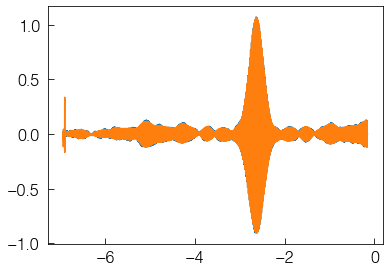

In [73]:
#plt.plot(x)
plt.figure()
plt.plot(x0,intfg0)#,x,intfg1)
plt.plot(xnew2,intfg_new2)#,x,intfg1)
#plt.xlim(-3.3,-3)
#plt.ylim(-2.7,-2)

(1600.0, 1700.0)

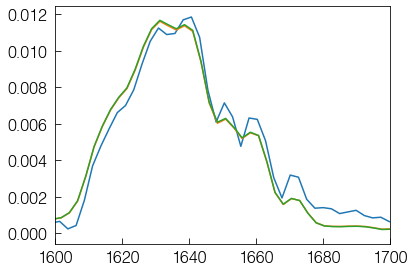

In [74]:
#result0=sd.fourier_xform([intfg0,x0],tsubtract=0,envelope=True)
result2=sd.fourier_xform([intfg_new2,xnew2],tsubtract=0,envelope=True)
plt.figure()
plt.plot(result0[0],result0[1])
plt.plot(result1[0],result1[1])
plt.plot(result2[0],result2[1])

plt.xlim(1600,1700)

# Simple mean of fwd/bwd

In [75]:
Ncycles = len(intfgs_arr) // 2
Nintfgms = Ncycles*2
Nx=100

all_xs_fwd = []
all_intfgs_fwd = []
all_xs_bwd = []
all_intfgs_bwd = []

for i in range(Ncycles):
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    xs*=delay_calibration_factor
    xs = numrec.smooth(xs,window_len=Nx,axis=0)
    
    indmin=np.argmin(xs)
    indmax=np.argmax(xs)
    
    
    

    #-- fwd:
    x = xs[:int(N // 2)]
    y = ys[:int(N // 2)]
    
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
    
    if i==0:
        x0=np.array(x)
        intfg0=np.array(y)
        
    all_xs_fwd.append(x); all_intfgs_fwd.append(y)
    
    #-- bwd
    x = xs[int(N // 2):]
    y = ys[int(N // 2):]
    
    x = numrec.smooth(x,window_len=Nx,axis=0)
    x,y=zip(*sorted(zip(x,y)))
    x=np.array(x); y=np.array(y)
    y-=np.polyval(np.polyfit(x=x,y=y,deg=flattening_order),x)
        
    all_xs_bwd.append(x); all_intfgs_bwd.append(y)
    
x_fwd=np.mean(all_xs_fwd,axis=0)
x_bwd=np.mean(all_xs_bwd,axis=0)
intfg_fwd=np.mean(all_intfgs_fwd,axis=0)
intfg_bwd=np.mean(all_intfgs_bwd,axis=0)

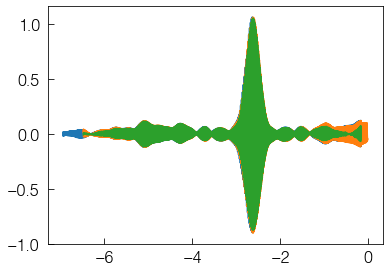

In [82]:
plt.plot(x_fwd,intfg_fwd)
plt.plot(x_bwd,intfg_bwd)

interp_fwd=interp1d(x=x_fwd,y=intfg_fwd,
                   **interp_kwargs)
interp_bwd=interp1d(x=x_bwd,y=intfg_bwd,
                   **interp_kwargs)
xcommon=np.linspace( np.max( (np.min(x_fwd),np.min(x_bwd)) ),
                     np.min( (np.max(x_fwd),np.max(x_bwd)) ),
                     int( np.mean( (len(x_fwd),len(x_bwd)) ) ) )
intfg_new = (interp_fwd(xcommon)+interp_bwd(xcommon))/2

plt.plot(xcommon,intfg_new)
#plt.xlim(-2.8,-2.6)

# Binning with rolling shift

In [139]:
from scipy.stats import binned_statistic
intfgs_arr=np.loadtxt('interferograms_test2.txt')

#Show robustness to noise
Ndat=intfgs_arr.shape[1]
noise=0.3

Ncycles = len(intfgs_arr) // 2
Ncycles = np.min((20,Ncycles))
Nintfgms = Ncycles*2

all_xs = []
all_ys = []
for i in range(Ncycles):
    #i=i+10
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    Nbins=len(xs)
    
    xs *= delay_calibration_factor
    xs = numrec.smooth(xs,window_len=Nx,axis=0)
    ys+=noise*np.random.randn(Ndat)*(ys.max()-ys.min())/2
    ys-=np.polyval(np.polyfit(x=xs,y=ys,deg=flattening_order),xs)
    
    if i==0:
        x0=xs
        y0=ys

    all_xs = np.append(all_xs,xs)
    all_ys = np.append(all_ys,ys)
    
def shifted_intfg(shift):
    
    all_xs_rolled=np.roll(all_xs,shift,axis=0)
    result = binned_statistic(all_xs_rolled,all_ys,bins=Nbins)
    xnew = result.bin_edges[:-1]
    intfg_new=result.statistic
    
    keep=np.isfinite(intfg_new)
    xnew=xnew[keep]
    intfg_new=intfg_new[keep]
    
    return xnew,intfg_new
    
    

shifts=np.arange(-100,100,1)
sums=[]
for shift in shifts:
    print(shift)
    xnew,intfg_new=shifted_intfg(shift)
    sums.append(np.sum(intfg_new**2))

shift = shifts[np.argmax(sums)]
print('Optimal shift',shift)
print('Dx=',np.diff(xnew)[0]*shift)
xnew, intfg_new = shifted_intfg(shift)

#intfg_interp = interp1d(x=xnew,y=intfg_new,
#                        **interp_kwargs)
#xnew=np.linspace(x1,x1+dX,len(xnew))
#intfg_new = intfg_interp(xnew)

xnew3=xnew
intfg_new3=intfg_new


-100
-99
-98
-97
-96
-95
-94
-93
-92
-91
-90
-89
-88
-87
-86
-85
-84
-83
-82
-81
-80
-79
-78
-77
-76
-75
-74
-73
-72
-71
-70
-69
-68
-67
-66
-65
-64
-63
-62
-61
-60
-59
-58
-57
-56
-55
-54
-53
-52
-51
-50
-49
-48
-47
-46
-45
-44
-43
-42
-41
-40
-39
-38
-37
-36
-35
-34
-33
-32
-31
-30
-29
-28
-27
-26
-25
-24
-23
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Optimal shift 27
Dx= 0.004041681732779523


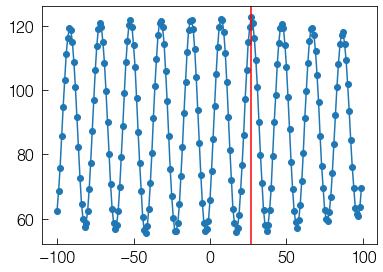

In [140]:
plt.plot(shifts,sums,marker='o')
plt.axvline(shift,color='r')
#plt.ylim(4,32)

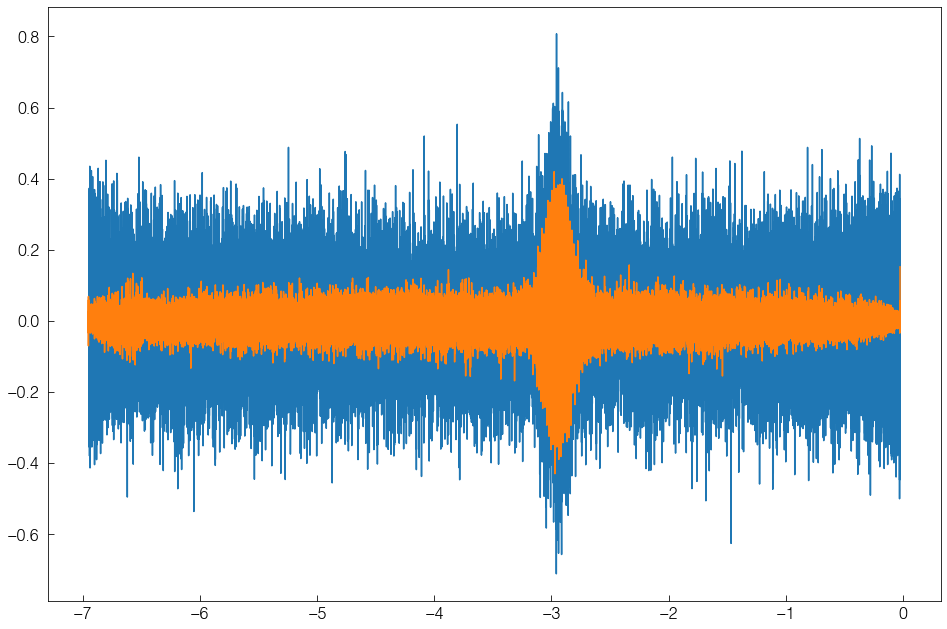

In [141]:
plt.figure(figsize=(16,10))
plt.plot(x0,y0)
plt.plot(xnew,intfg_new)
#plt.xlim(-2.8,-2.6)

# Fitting Fwd / bwd to infer shift, then roll to fit

In [367]:
def g(x,args):
    
    a,x0,dx = args
    return a*np.exp(-(x-x0)**2/(2*dx**2))

def get_x0(x,y,exp=2):

    global yup
    yup = np.abs(y)**exp
    x0 = np.mean(x)
    args0 = (np.std(yup),x0,np.mean(x)/10)
    
    global gout
    args,_ = numrec.ParameterFit(xs=x,
                                ys=yup,
                                model_func=g,
                                params0 = args0)
    gout = g(x,args)
    
    return args[1]
    
    

In [579]:
def get_dx(intfg_mutual_fwd,intfg_mutual_bwd,exp=4):
    
    sf = num.Spectrum(intfg_mutual_fwd,axis=0); sfabs=np.abs(sf)
    sb = num.Spectrum(intfg_mutual_bwd,axis=0); sbabs=np.abs(sb)
    spow = np.abs(sf)**exp+np.abs(sb)**exp
    keep = (spow >= spow.max()/10)*(sf.axes[0]>0)
    norm=sf/sb
    norm = numrec.smooth(norm,window_len=5,axis=0)
    norm = norm[keep]
    spow = spow[keep]
    f,p=norm.axes[0],np.angle(norm)
    
    p=np.polyfit(x=f,y=p,w=spow,deg=1)
    dx = -p[0]/(2*np.pi)
    
    return dx

def get_x0(intfg_mutual_fwd,intfg_mutual_bwd,exp=2):
    
    global intfg_fwd_fil,intfg_bwd_fil
    x=intfg_mutual_fwd.axes[0]
    
    intfg_fwd = intfg_mutual_fwd
    intfg_bwd = intfg_mutual_bwd
    w = np.abs(intfg_fwd)**exp + np.abs(intfg_bwd)**exp
    
    x0 = np.sum(x*w)/np.sum(w)
    
    return x0

x0: -3.497570882513451
Fwd/bwd dx separation: -0.010375897544224228
Initially optimal shift: -12
-22
-21
-20
-19
-18
-17
-16
-15
-14
-13
-12
-11
-10
-9
-8
-7
-6
-5
-4
-3
Finally optimal shift: -13


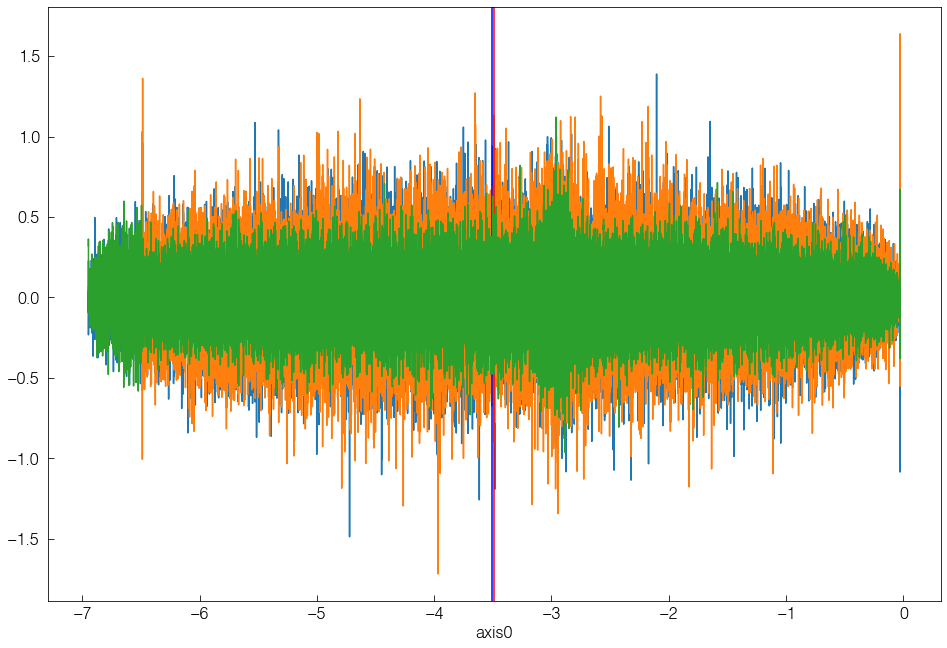

In [585]:
intfg_file = 'interferograms_test2.txt'
intfgs_arr=np.loadtxt(intfg_file)

#Show robustness to noise
Ndat=intfgs_arr.shape[1]
noise=1.5

Ncycles = len(intfgs_arr) // 2
Nsamples = intfgs_arr.shape[1]
x_smoothing = np.min((Nsamples/100,50))

#--- Process data
all_xs_fwd = []
all_ys_fwd = []
all_xs_bwd = []
all_ys_bwd = []
all_xs = []
all_ys = []
for i in range(Ncycles):
    #i=i+10
    ys, xs = np.array(intfgs_arr[2 * i:2 * (i+1)])
    Nbins=len(xs)
    
    xs *= delay_calibration_factor
    xs = numrec.smooth(xs,window_len=x_smoothing,axis=0)
    
    ys+=noise*np.random.randn(Ndat)*(ys.max()-ys.min())/2
    ys-=np.polyval(np.polyfit(x=xs,y=ys,deg=flattening_order),xs)
    
    if i==0:
        x0=xs
        y0=ys
        Nbins = len(xs)
        idx_turn = np.argmax(xs)

    all_xs_fwd.append(xs[:idx_turn])
    all_ys_fwd.append(ys[:idx_turn])

    all_xs_bwd.append(xs[idx_turn:])
    all_ys_bwd.append(ys[idx_turn:])
    
    all_xs.append(xs); all_ys.append(ys)
    
#--- Get fwd/bwd interferograms
all_xs_fwd = np.array(all_xs_fwd)
all_xs_bwd = np.array(all_xs_bwd)
all_ys_fwd = np.array(all_ys_fwd)
all_ys_bwd = np.array(all_ys_bwd)
all_xs=np.array(all_xs).flatten()
all_ys=np.array(all_ys).flatten()

result = binned_statistic(all_xs_fwd.flatten(),
                          all_ys_fwd.flatten(),
                          bins=Nbins)
x_fwd = result.bin_edges[:-1]
intfg_fwd=result.statistic
intfg_fwd[~np.isfinite(intfg_fwd)]=0
intfg_fwd = AWA(intfg_fwd, axes=[x_fwd])

result = binned_statistic(all_xs_bwd.flatten(),
                          all_ys_bwd.flatten(),
                          bins=Nbins)
x_bwd = result.bin_edges[:-1]
intfg_bwd=result.statistic
intfg_bwd[~np.isfinite(intfg_bwd)]=0
intfg_bwd = AWA(intfg_bwd, axes=[x_bwd])

xmin = np.max((np.min(x_fwd),np.min(x_bwd)))
xmax = np.min((np.max(x_fwd),np.max(x_bwd)))
xmutual = np.linspace(xmin,xmax,Nbins)
intfg_mutual_fwd = intfg_fwd.interpolate_axis(xmutual,axis=0)
intfg_mutual_bwd = intfg_bwd.interpolate_axis(xmutual,axis=0)

#-- Find average characteristic index of x0_fwd vs x0_bwd = shift0
#dx = get_dx(intfg_mutual_fwd,intfg_mutual_bwd,exp=2)
#x0 = get_x0(intfg_mutual_fwd,intfg_mutual_bwd,exp=2)
#x0_fwd = x0+dx/2
#x0_bwd = x0-dx/2
x0 = get_x0(intfg_mutual_fwd,intfg_mutual_bwd,exp=4)
print('x0:',x0)
dx=get_dx(intfg_mutual_fwd,intfg_mutual_bwd,exp=4)
print('Fwd/bwd dx separation:',dx)
x0_fwd = x0+dx/2
x0_bwd = x0-dx/2

dns=[]
for xs_fwd in all_xs_fwd:
    n2 = np.argmin(np.abs(xs_fwd - x0_fwd))
    n1 = np.argmin(np.abs(xs_fwd - x0_bwd))
    dns.append( (n2-n1)/2. )

shift0=np.int(np.round(np.mean(dns)))
print('Initially optimal shift:',shift0)

#-- Optimize around shift0
#optimize=False
optimize=True
if optimize:
    def shifted_intfg(shift):

        all_xs_rolled=np.roll(all_xs,shift,axis=0)
        result = binned_statistic(all_xs_rolled,all_ys,bins=Nbins)
        xnew = result.bin_edges[:-1]
        intfg_new=result.statistic

        keep=np.isfinite(intfg_new)
        intfg_new[~keep]=0

        return xnew,intfg_new

    shifts=np.arange(-10,10,1)+shift0
    sums=[]
    for shift in shifts:
        print(shift)
        xnew,intfg_new=shifted_intfg(shift)
        sums.append(np.sum(intfg_new**2))
    shift0 = shifts[np.argmax(sums)]

print('Finally optimal shift:',shift0)
x,intfg = shifted_intfg(shift0)
intfg = AWA(intfg,axes=[x])


plt.figure(figsize=(16,10))
intfg_fwd.plot()
intfg_bwd.plot()
plt.axvline(x0_fwd,color='b')
plt.axvline(x0_bwd,color='r')
intfg.plot()
x0=intfg.axes[0][np.argmax(intfg)]; dx=.1
#plt.xlim(x0-dx,x0+dx)

f,sabs,p,_,_ = sd.fourier_xform([np.array(intfg), x],tsubtract=0,envelope=True)

# Compare methods

In [111]:
reload(sd)

<module 'mnOPSuite.PRISM.python.scandelay_FTIR' from 'C:\\Users\\mnopl\\Desktop\\Software\\mnOPSuite\\PRISM\\python\\scandelay_FTIR.py'>

In [112]:
pdb off

Automatic pdb calling has been turned OFF


In [113]:
intfg_file = 'interferograms.txt'
intfgs_arr=np.loadtxt(intfg_file)
noise=0#.2

In [114]:
result0 = sd. align_interferograms_old(intfgs_arr, delay_calibration_factor=delay_calibration_factor,
                         shift0=0,optimize_shift=True,shift_range=15,
                         flattening_order=20, noise=noise)

Optimal shift: -13


In [115]:
f0,sabs0,p0,_,_ = sd.fourier_xform(result0,tsubtract=0,envelope=True)

In [116]:
result1 = sd. align_interferograms_fwd_bwd(intfgs_arr, delay_calibration_factor=delay_calibration_factor,
                         delay0=0,optimize_delay=True,delay_range=15,
                         flattening_order=20, noise=noise)

In [117]:
f1,sabs1,p1,_,_ = sd.fourier_xform_fwd_bwd(result1,tsubtract=0,envelope=True)

In [118]:
result = sd.align_interferograms_new(intfgs_arr, delay_calibration_factor=delay_calibration_factor,
                                 shift0=0,optimize_shift=True,shift_range=10,
                                 flattening_order=10,noise=noise)

x0: 15.80192738804993


TypeError: expected non-empty vector for x

In [107]:
f,sabs,p,_,_ = sd.fourier_xform(result,tsubtract=0,envelope=True)

# Compare

(500.0, 1000.0)

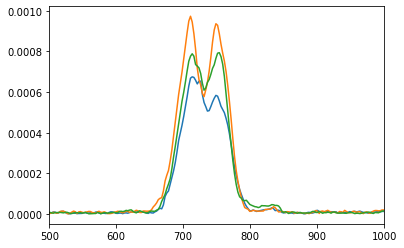

In [108]:
plt.plot(f0,sabs0)
plt.plot(f1,sabs1)
plt.plot(f,sabs)
#plt.xlim(800,1100)
plt.xlim(500,1000)
#plt.gca().set_yscale('log')

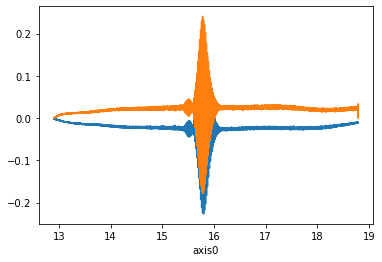

In [119]:
sd.intfg_mutual_fwd.plot()
sd.intfg_mutual_bwd.plot()
#plt.xlim(15.5,15.55)

In [129]:
exp=2
sf = num.Spectrum(sd.intfg_mutual_fwd-np.mean(sd.intfg_mutual_fwd), axis=0)
sb = num.Spectrum(sd.intfg_mutual_bwd-np.mean(sd.intfg_mutual_bwd), axis=0)
spow = np.abs(sf) ** exp + np.abs(sb) ** exp
keep = (spow >= spow.max() / 10) * (sf.axes[0] > 0)
norm = sf / sb
norm = numrec.smooth(norm, window_len=5, axis=0)
norm = norm[keep]
spow = spow[keep]
f, p = norm.axes[0], np.unwrap(np.angle(norm))

p = np.polyfit(x=f, y=p, w=spow, deg=1)
dx = -p[0] / (2 * np.pi)

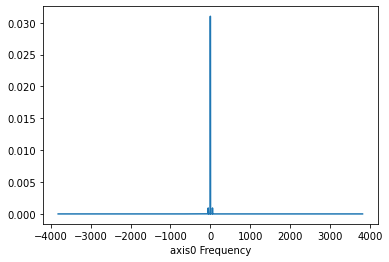

In [127]:
spow = np.abs(sf) ** exp + np.abs(sb) ** exp
spow.plot()